# Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-e4e07f4b-d399-eb04-8bc7-bb00d0cd51f8)


# Initial Imports

In [2]:
import numpy as np
import pandas as pd
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using {device.type.upper()}')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using CUDA
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


## Text Cleaning

In [3]:
import re
import string

def remove_html_tag(text): 
    return re.sub(
        '<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', 
        '', text)

## Load Dataset and Clean Text

In [4]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df['clean_text'] = df.review.apply(remove_html_tag)
df

,review,sentiment,clean_text
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...,...,...
49995,I thought this movie did a down right good job...,positive,I thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"Bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,I am a Catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,I'm going to have to disagree with the previou...


## Token Length Exploration

In [5]:
df.clean_text.apply(lambda x: len(x.split(' '))).describe()

count    50000.00000
mean       227.10428
std        168.26324
min          4.00000
25%        124.00000
50%        170.00000
75%        275.00000
max       2450.00000
Name: clean_text, dtype: float64

## Data Preparation

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [7]:
class BertDataset(torch.utils.data.Dataset):
    def __init__(self, df, bert_model_name='bert-base-cased'):
        self.review = df.clean_text
        self.sentiment = df.sentiment.apply(lambda x: 1 if x == 'positive' else 0)
        self.tokenizer = BertTokenizerFast.from_pretrained(bert_model_name)
        
    def __len__(self):
        return len(self.sentiment)
    
    def __getitem__(self, idx):
        x = self.tokenize(self.review[idx])
        for key in x:
            x[key] = x[key].view(-1).to(device)
        y = self.sentiment[idx]
        return x, y
    
    def tokenize(self, x):
        x = self.tokenizer(x, max_length=256, padding='max_length', 
                              truncation=True, return_tensors='pt')
        return x

In [8]:
from transformers import BertTokenizerFast

trainloader = torch.utils.data.DataLoader(BertDataset(df_train), batch_size=32)
testloader = torch.utils.data.DataLoader(BertDataset(df_test), batch_size=32)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

# Model Definition and Training

In [9]:
from transformers import BertModel

class BertClassifier(torch.nn.Module):
    def __init__(self, bert_model_name='bert-base-cased', bert_freeze=False):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        for param in self.bert.parameters():
            param.requires_grad = False if bert_freeze else True
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 1)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(input_ids, attention_mask, token_type_ids).pooler_output
        out = self.dropout(out)
        out = torch.sigmoid(self.classifier(out)).view(-1)
        return out

In [10]:
model = BertClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), 2e-5)
loss = torch.nn.BCELoss()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [11]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train(epoch, model, optimizer, loss_fn, dataloader):
    # Enable training
    model.train()
    with tqdm(dataloader, total=len(dataloader)) as pbar:
        accuracy = []
        losses = []
        pbar.set_description('Epoch %d - Training\t' %(epoch + 1))
        for x, y in pbar:
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Convert label for specified device and to float type
            y = y.to(device).float()
                
            # Update weights and parameters by, forward + backward + optimize
            y_pred = model(**x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            
            # Convert tensors to CPU mode and integer type
            y = y.cpu().int()
            y_pred = (y_pred > 0.5).cpu().int()
            
            # Add metrics record to lists
            accuracy.append(accuracy_score(y, y_pred))
            losses.append(loss.item())
            
            # Store average of metrics
            history = {'training_loss': np.mean(losses), 
                       'training_accuracy': np.mean(accuracy)}
            # Update progress bar
            pbar.set_postfix(history)
        return history
    
def evaluate(epoch, model, loss_fn, dataloader):
    # Disable training
    model.eval()
    with torch.no_grad(), tqdm(dataloader, total=len(dataloader)) as pbar:
        accuracy = []
        losses = []
        pbar.set_description('Epoch %d - Validation\t' %(epoch + 1))
        for x, y in pbar:
            # Generate prediction
            y_pred = model(**x)
            
            # Convert label for specified device and to float type
            y = y.to(device).float()
            
            # Compute loss
            loss = loss_fn(y_pred, y)
            
            # Convert tensors to CPU mode and integer type
            y_pred = (y_pred > 0.5).cpu().int()
            y = y.cpu().int()
            
            # Add metrics record to lists
            accuracy.append(accuracy_score(y, y_pred))
            losses.append(loss.item())
            
            # Store average of metrics
            history = {'validation_loss': np.mean(losses), 
                       'validation_accuracy': np.mean(accuracy)}
            
            # Update progress bar
            pbar.set_postfix(history)
        return history

In [12]:
history = [{**train(epoch, model, optimizer, loss, trainloader),
            **evaluate(epoch, model, loss, testloader)}
           for epoch in range(5)]

Epoch 5 - Validation	: 100%|██████████| 313/313 [01:32<00:00,  3.40it/s, validation_loss=0.277, validation_accuracy=0.923]


In [13]:
training_loss = [h['training_loss'] for h in history]
validation_loss = [h['validation_loss'] for h in history]
training_accuracy = [h['training_accuracy'] for h in history]
validation_accuracy = [h['validation_accuracy'] for h in history]

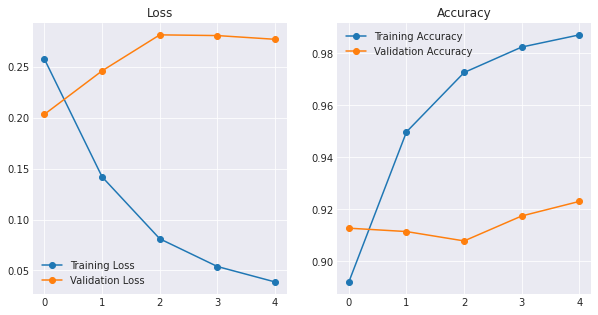

In [14]:
import matplotlib.pyplot as plt

# Styling
plt.style.use('seaborn-darkgrid')

# Initialize plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
# Left plot
ax1.set_title('Loss')
ax1.plot(training_loss, 'o-', label='Training Loss')
ax1.plot(validation_loss, 'o-', label='Validation Loss')
ax1.legend()
# Right plot
ax2.set_title('Accuracy')
ax2.plot(training_accuracy, 'o-', label='Training Accuracy')
ax2.plot(validation_accuracy, 'o-', label='Validation Accuracy')
ax2.legend()
fig.show()